In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/temp-anomaly-detector/ambient_temperature_system_failure (1).csv


In [2]:
def pca(X, num_components, return_cumulative_variance=False):
    # Step 1: Standardize the data
    X_meaned = X - np.mean(X, axis=0)
    
    # Step 2: Covariance matrix
    cov_matrix = np.cov(X_meaned, rowvar=False)
    
    # Step 3: Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Step 4: Sort eigenvalues and eigenvectors
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    sorted_eigenvectors = eigenvectors[:, sorted_index]
    
    # Step 5: Projection matrix
    eigenvector_subset = sorted_eigenvectors[:, 0:num_components]
    
    # Step 6: Transform the data
    X_reduced = np.dot(eigenvector_subset.transpose(), X_meaned.transpose()).transpose()
    if return_cumulative_variance:
        # Compute explained variance ratio
        explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
        # Compute cumulative explained variance ratio
        cumulative_explained_variance = np.cumsum(explained_variance_ratio[:num_components])
        return X_reduced, cumulative_explained_variance
    else:
        return X_reduced
    

def get_distance_by_point(data, model):
    if data.empty:
        return pd.Series(dtype=float)
    
    # Extract the cluster centers and labels
    cluster_centers = model.cluster_centers_
    labels = model.labels_
    
    # Calculate the distances using vectorized operations
    distances = np.linalg.norm(data.values - cluster_centers[labels], axis=1)
    
    # Convert the numpy array to a pandas Series with the same index as the input data
    return pd.Series(distances, index=data.index)

# **I) Chuẩn bị và trực quan hóa dữ liệu** #

**1) Chuẩn bị dữ liệu**

Dữ liệu nhiệt độ theo thời gian của 1 văn phòng: [Temp_anomly_detection](file:///C:/Users/Admin/Downloads/D%E1%BB%B1%20%C3%A1n%20newbie%20-%20Ph%C3%A1t%20hi%E1%BB%87n%20b%E1%BA%A5t%20th%C6%B0%E1%BB%9Dng%20trong%20d%E1%BB%AF%20li%E1%BB%87u%20chu%E1%BB%97i%20th%E1%BB%9Di%20gian%20s%E1%BB%AD%20d%E1%BB%A5ng%20ph%C3%A9p%20ph%C3%A2n%20t%C3%ADch%20th%C3%A0nh%20ph%E1%BA%A7n%20ch%C3%ADnh.pdf)

In [3]:
Temp=pd.read_csv("/kaggle/input/temp-anomaly-detector/ambient_temperature_system_failure (1).csv",parse_dates=True)
Temp.head(5)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [4]:
Temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [5]:
Temp.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


Dữ liệu nhiệt độ phòng được đo mỗi giờ liên tục trong hơn 300 ngày
Nhiệt độ của phòng dao động từ 57 đến 86 độ F, với giá trị trung bình là 71 độ F
Để thuận tiện cho tính toán, ta sẽ quy đổi nhiệt độ sang độ C và làm tròn đến số thập phân hàng trăm 

In [6]:
Temp["value"]=Temp["value"].apply(lambda x: round((x-32)*5/9,2))

**2) Trực quan hóa dữ liệu**

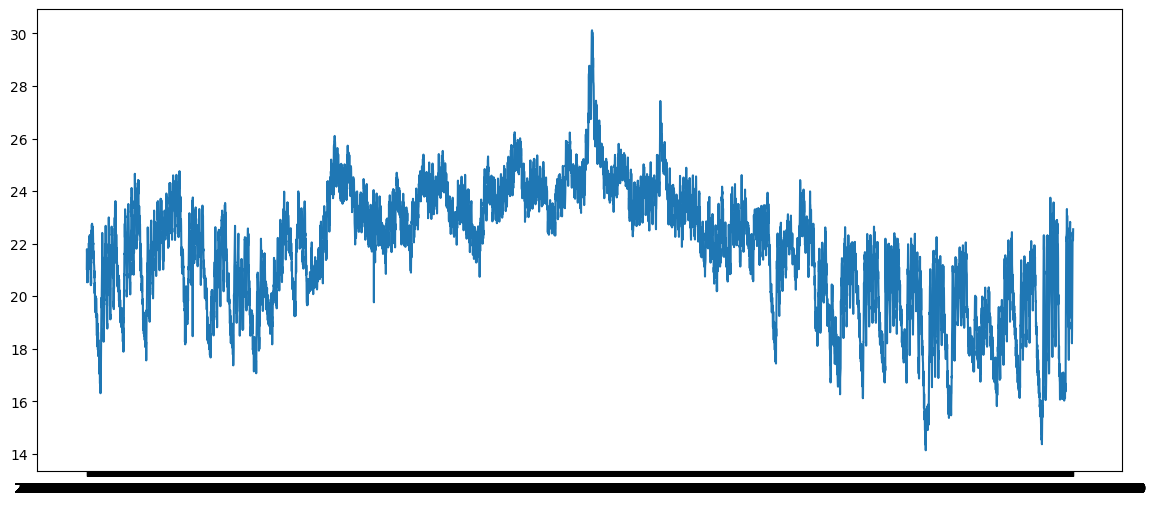

In [7]:
X=Temp["timestamp"]
y=Temp["value"]

fig,ax=plt.subplots(figsize=(14,6))
ax.plot(X,y)

Tiếp theo ta sẽ trích xuất các feature chuẩn bị cho thuật toán PCA

# **II) Feature Engineering**

Ta sẽ trích xuất từ cột thời gian ra các features có thể ảnh hưởng đến nhiệt độ như: sáng tối trưa chiều (hours), 4 mùa (months),...

In [8]:
Temp['timestamp']=pd.to_datetime(Temp["timestamp"])
Temp['hours']=Temp['timestamp'].dt.hour
Temp['months']=Temp['timestamp'].dt.month

Với mỗi feature ta sẽ dùng thuật toán phân cụm để phân loại tốt hơn

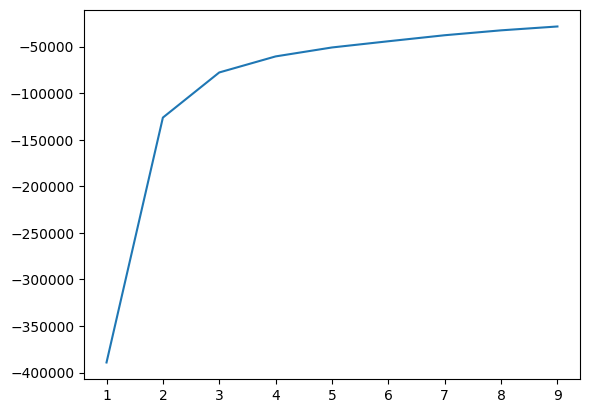

In [9]:
#Elbow method 
df=Temp[['hours','value']]
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i,n_init=10).fit(df) for i in n_cluster]
scores = [kmeans[i].score(df) for i in range(len(kmeans))]

fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

(array([304., 304.,   0., 303.,   0., 303., 302.,   0., 301.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

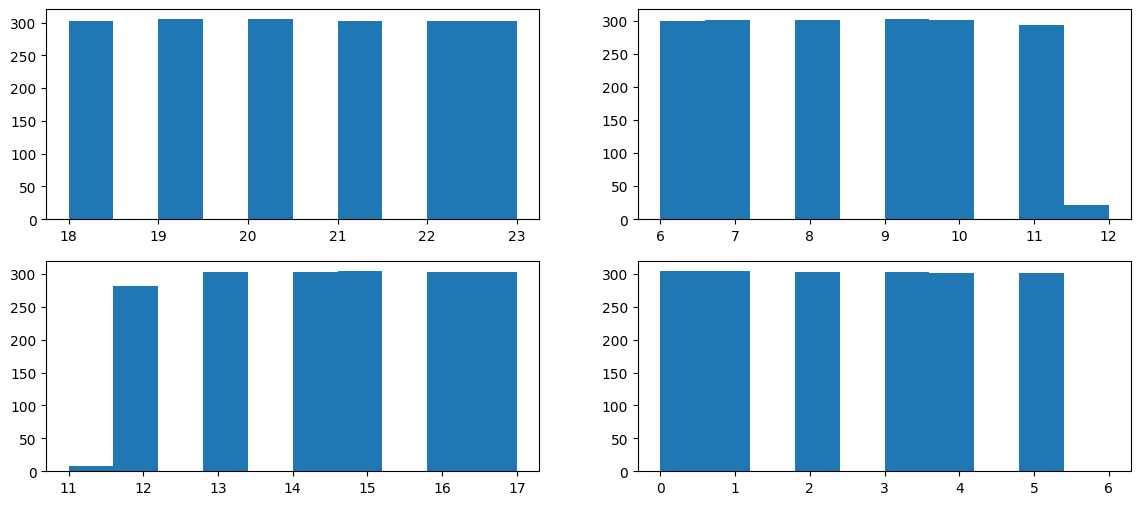

In [10]:
Temp['hours_distinguish']=kmeans[3].predict(df)
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(14,6))
ax1.hist(Temp.loc[Temp['hours_distinguish']==0,'hours'])
ax2.hist(Temp.loc[Temp['hours_distinguish']==1,'hours'])
ax3.hist(Temp.loc[Temp['hours_distinguish']==2,'hours'])
ax4.hist(Temp.loc[Temp['hours_distinguish']==3,'hours'])

In [11]:
Temp['night']=((Temp['hours'] > 0) & (Temp['hours'] <6) ).astype(int)
Temp['morning']=((Temp['hours'] > 5) & (Temp['hours'] <12) ).astype(int)
Temp['afternoon']=((Temp['hours'] > 11) & (Temp['hours'] <18) ).astype(int)
Temp['evening']=((Temp['hours'] > 17) & (Temp['hours'] <24) ).astype(int)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ae116548580>,
 'caps': [<matplotlib.lines.Line2D at 0x7ae11654a500>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ae116549e70>],
 'medians': [<matplotlib.lines.Line2D at 0x7ae1165483a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ae116549360>],
 'means': []}

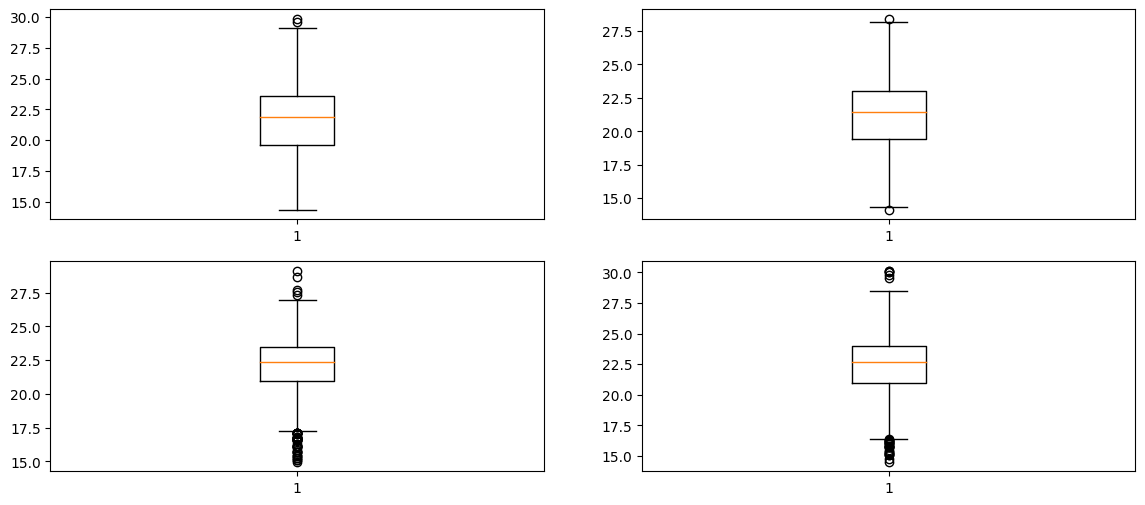

In [12]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(14,6))
ax1.boxplot(Temp.loc[Temp['night']==1,'value'])
ax2.boxplot(Temp.loc[Temp['morning']==1,'value'])
ax3.boxplot(Temp.loc[Temp['afternoon']==1,'value'])
ax4.boxplot(Temp.loc[Temp['evening']==1,'value'])

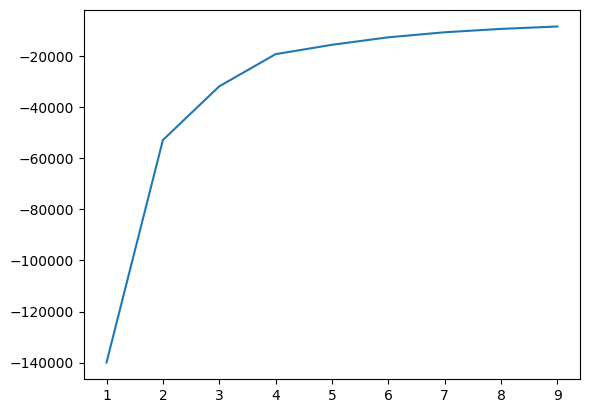

In [13]:
df=Temp[['months','value']]
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i,n_init=10).fit(df) for i in n_cluster]
scores = [kmeans[i].score(df) for i in range(len(kmeans))]

fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

(array([ 52.,   0., 478.,   0., 505.,   0., 550.,   0.,   0.,  30.]),
 array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 <BarContainer object of 10 artists>)

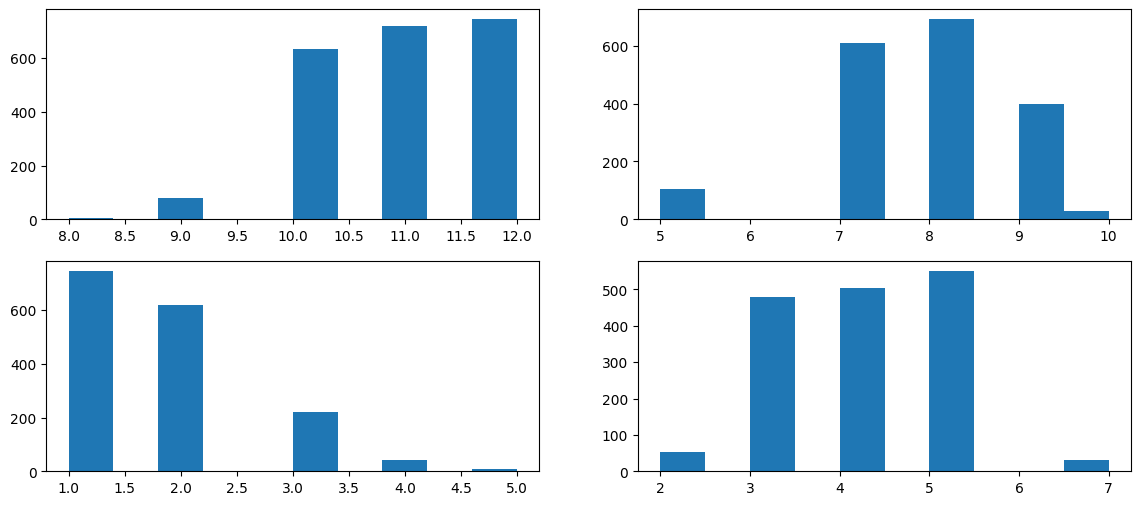

In [14]:
Temp['months_distinguish']=kmeans[3].predict(df)
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(14,6))
ax1.hist(Temp.loc[Temp['months_distinguish']==0,'months'])
ax2.hist(Temp.loc[Temp['months_distinguish']==1,'months'])
ax3.hist(Temp.loc[Temp['months_distinguish']==2,'months'])
ax4.hist(Temp.loc[Temp['months_distinguish']==3,'months'])

Như vậy với số cluster là 4, ta sẽ chia 12 tháng theo 4 mùa xuân hạ thu đông, là hợp lí khi sự thay đổi mùa cũng dẫn đến thay đổi nhiệt độ

In [15]:
Temp['Spring']=((Temp['months']>=1)&(Temp['months']<=2)).astype(int)
Temp['Summer']=((Temp['months']>=3)&(Temp['months']<=5)).astype(int)
Temp['Autumn']=((Temp['months']>=7)&(Temp['months']<=9)).astype(int)
Temp['Winter']=((Temp['months']>=10)&(Temp['months']<=12)).astype(int)

In [16]:
Temp['DayOfTheWeek'] = Temp['timestamp'].dt.dayofweek
Temp['WeekDay'] = (Temp['DayOfTheWeek'] < 5).astype(int)

In [17]:
data = Temp[['value', 'hours', 'morning','afternoon','evening','night', 'Spring','Summer','Autumn','Winter','DayOfTheWeek']]
#Chuẩn hóa dữ liệu
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

#Giảm chiều tuy vào lượng thông tin được giữ lại (ở đây khi giữ lại 8 thành phần thì 98% lượng thông tin được bảo lưu)
data, ratio=pca(data,8,True)
                    
# Chuẩn hóa 1 lần nữa
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
print(ratio)

#THUẬT CÓ SẴN CỦA SCIKIT_LEARN
#min_max_scaler = preprocessing.StandardScaler()
#np_scaled = min_max_scaler.fit_transform(data)
#pca = PCA(n_components=8)
#data = pca.fit_transform(data)
#data = pd.DataFrame(data)
#min_max_scaler = preprocessing.StandardScaler()
#np_scaled = min_max_scaler.fit_transform(data)
#exp_var_pca = pca.explained_variance_ratio_
#cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#print(cum_sum_eigenvalues)
#plt.scatter(data[0],data[1])

[0.20983445 0.39314841 0.51572164 0.63690788 0.75580814 0.87197014
 0.96304833 0.98592197]


Tiếp theo ta sẽ phân cụm dữ liệu giảm chiều sau đó tính khoảng cách mỗi điểm đến cluster tương ứng, từ đó các điểm có khoảng cách lớn sẽ chính là điểm bất thường trong nhiệt độ

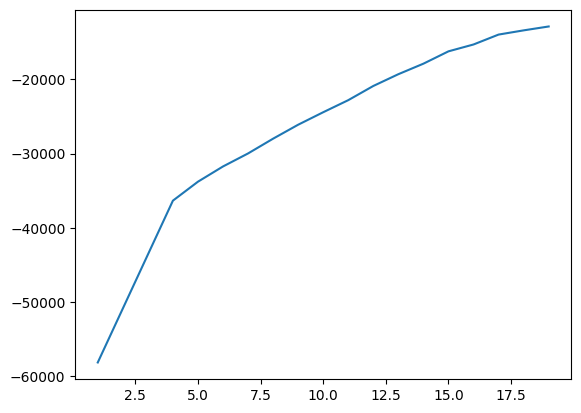

In [18]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i,n_init=10).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [19]:
cluster=10
outliers_fraction=0.05

#Phân cụm
Temp['cluster'] = kmeans[cluster-1].predict(data)

#Tính khoảng cách
distance = get_distance_by_point(data, kmeans[cluster-1])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# Đánh dấu các anomalies 
Temp['anomaly21'] = (distance >= threshold).astype(int)

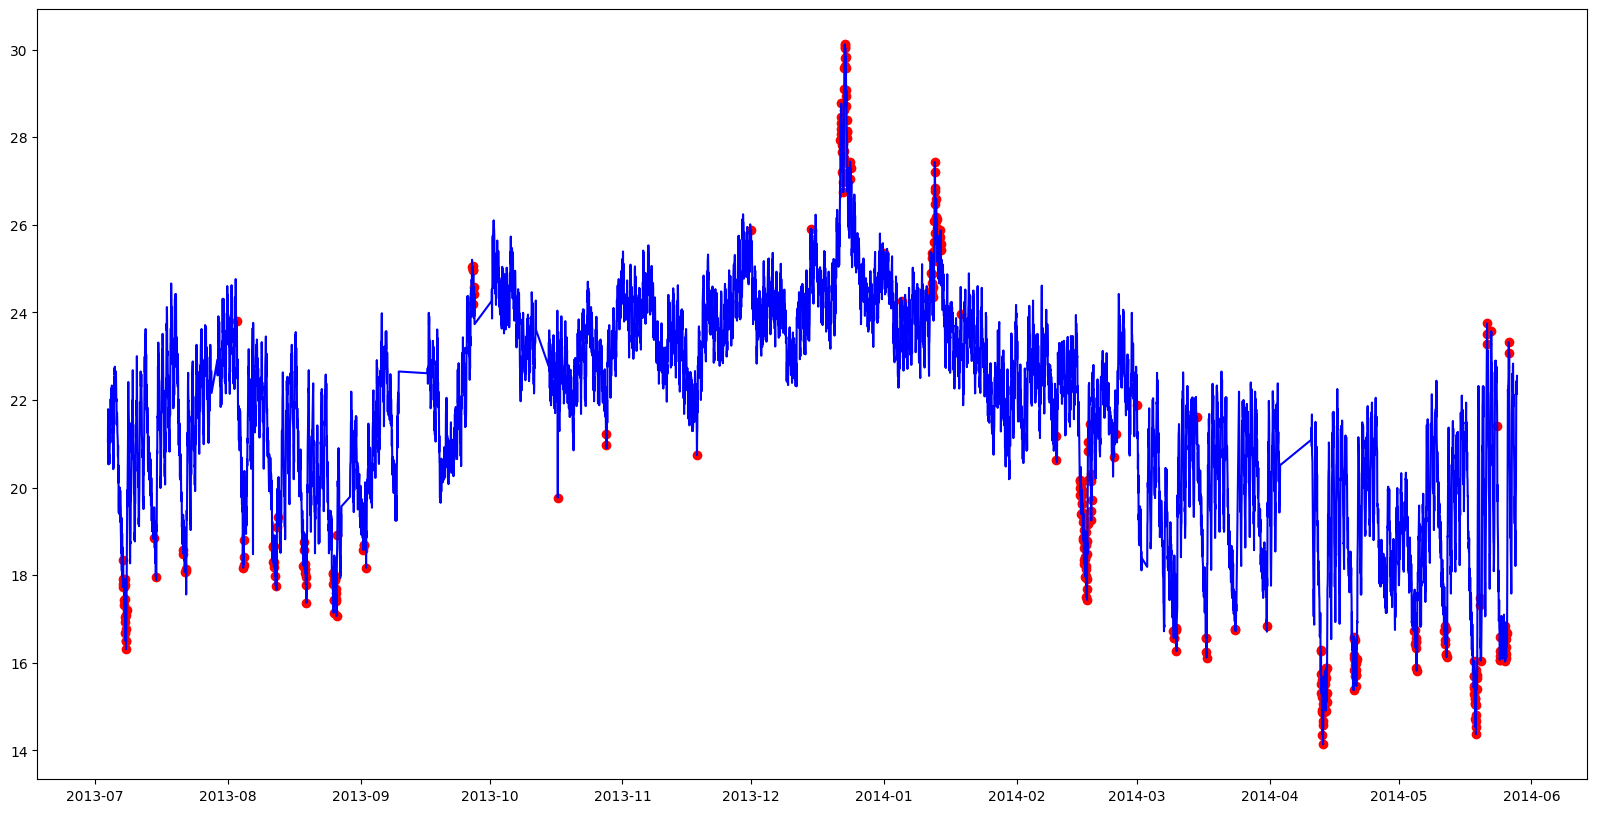

In [20]:
fig, ax = plt.subplots(figsize=(20,10))

a = Temp.loc[Temp['anomaly21'] == 1, ['timestamp', 'value']] #anomaly
ax.plot(Temp['timestamp'], Temp['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

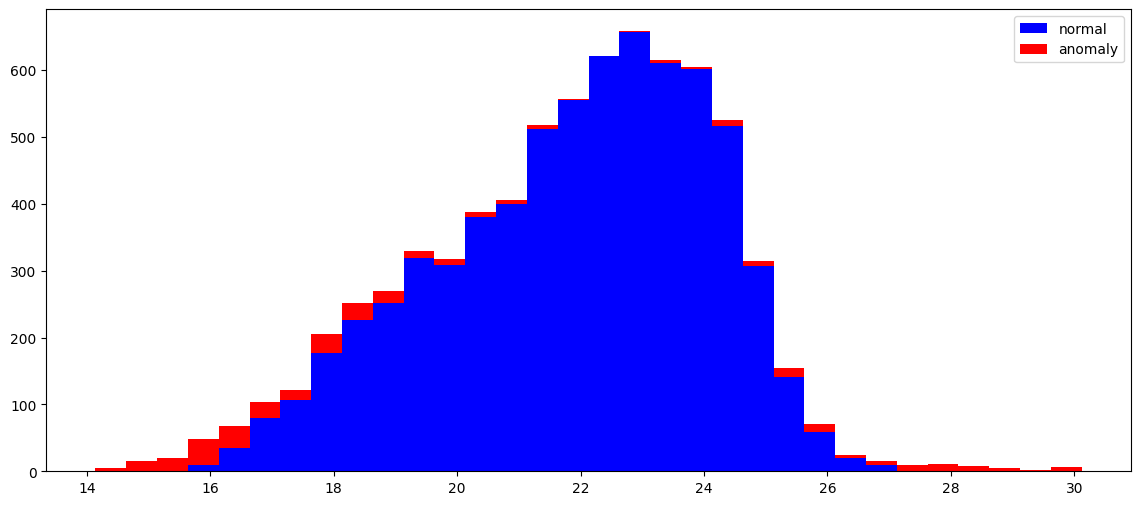

In [21]:
a = Temp.loc[Temp['anomaly21'] == 0, 'value']
b = Temp.loc[Temp['anomaly21'] == 1, 'value']

fig, axs = plt.subplots(figsize=(14,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()